<a href="https://colab.research.google.com/github/skzv/vizier-blog-post/blob/main/vizier_blog_post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install google-vizier==0.0.4
! pip3 install --upgrade google-cloud-aiplatform -q

In [1]:
from google.colab import auth as google_auth

google_auth.authenticate_user()

### Generating data

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import laplace

x = np.linspace(-10, 10.0, num=150)
A = 100


#### Guassian

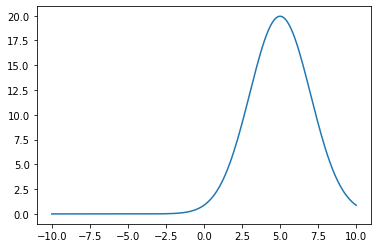

In [90]:
y_g = A * norm.pdf(x, 5, 2);

plt.plot(x, y_g)

### Laplace

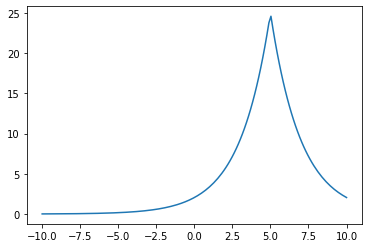

In [91]:
y_l= A * laplace.pdf(x, 5, 2);

plt.plot(x, y_l)

### Add some noise!

In [92]:
r = np.random.normal(0, 1, 150)
y_g_r = y_g + r
y_l_r = y_l + r

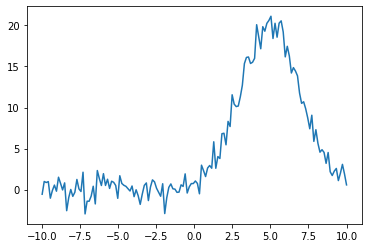

In [93]:
plt.plot(x, y_g_r)

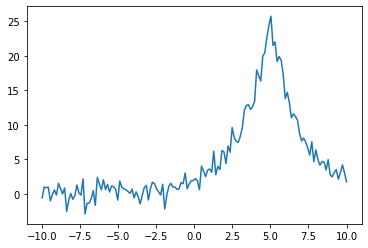

In [94]:
plt.plot(x, y_l_r)

In [95]:
from google.cloud import aiplatform

In [96]:
import datetime

REGION = "us-central1"
PROJECT_ID = "vizier-blog-post"

ENDPOINT = REGION + '-aiplatform.googleapis.com'
PARENT = 'projects/{}/locations/{}'.format(PROJECT_ID, REGION)

In [99]:
param_model = {
    'parameter_id': 'model',
    'categorical_value_spec' : {
        'values': [
            'gaussian',
            'laplace',
        ]
    },
    'conditional_parameter_specs': [
      {
        "parameter_spec": {
          "parameter_id": "mu",
          "scale_type": 'UNIT_LINEAR_SCALE',
          "double_value_spec": {
            "min_value": 0,
            "max_value": 10.0,
          },
        },
        "parent_categorical_values": {
          "values": ['gaussian']
        }
      },
      {
        "parameter_spec": {
          "parameter_id": "sigma",
          "scale_type": 'UNIT_LINEAR_SCALE',
          "double_value_spec": {
            "min_value": 1e-1,
            "max_value": 5.0,
          },
        },
        "parent_categorical_values": {
          "values": ['gaussian']
        }
      },
      {
        "parameter_spec": {
          "parameter_id": "a",
          "scale_type": 'UNIT_LINEAR_SCALE',
          "double_value_spec": {
            "min_value": 0,
            "max_value": 10.0,
          },
        },
        "parent_categorical_values": {
          "values": ['laplace']
        }
      },
      {
        "parameter_spec": {
          "parameter_id": "b",
          "scale_type": 'UNIT_LINEAR_SCALE',
          "double_value_spec": {
            "min_value": 1e-1,
            "max_value": 5.0,
          },
        },
        "parent_categorical_values": {
          "values": ['laplace']
        }
      },
    ],
}

metric_ssr = {
    'metric_id': 'sum_of_squared_residuals',
    'goal': 'MINIMIZE',
}

study = {
    'display_name': 'vizier_experiment',
    'study_spec' :
    {
        'parameters': [param_model],
        'metrics': [metric_ssr]
    }
}

In [100]:
vizier_client = aiplatform.gapic.VizierServiceClient(client_options=dict(api_endpoint=ENDPOINT))
study = vizier_client.create_study(parent=PARENT, study=study)

STUDY_ID = study.name
print("STUDY_ID: {}".format(STUDY_ID))

STUDY_ID: projects/75551437443/locations/us-central1/studies/1715977094819


In [101]:
def ParseParameter(parameters, id):
  for parameter in parameters:
    if parameter.parameter_id == id:
      return parameter.value

def GenerateFit(parameters):
  model = ParseParameter(parameters, 'model')

  if model == 'gaussian':
    mu = ParseParameter(parameters, 'mu')
    sigma = ParseParameter(parameters, 'sigma')
    y = A * norm.pdf(x, mu, sigma)
    print("[model = {}, mu = {}, sigma = {}]".format(model, mu, sigma))

  if model == 'laplace':
    a = ParseParameter(parameters, 'a')
    b = ParseParameter(parameters, 'b')
    print("[model = {}, a = {}, b = {}]".format(model, a, b))
    y = A * laplace.pdf(x, a, b)

  return y

def SumOfSquaresOfResidualsMetric(parameters):
  model = ParseParameter(parameters, 'model')

  y = GenerateFit(parameters)

  residuals = y_l_r - y
  ssr = np.sum(residuals**2)

  print("sum_of_squares_of_residuals => {}".format(ssr))
    
  return ssr

def CreateMetrics(trial_id, parameters):
  print(("=========== Start Trial: [{}] =============").format(trial_id))

  # Evaluate both objective metrics for this trial
  ssr = SumOfSquaresOfResidualsMetric(parameters)

  # Return the results for this trial
  return {
        'trial_name': trial_id,
        'measurement': {
            'metrics': [{'metric_id': 'sum_of_squares_of_residuals', 'value': ssr }]
        }
    }

### Set configuration parameters for running trials

__`client_id`__: The identifier of the client that is requesting the suggestion. If multiple SuggestTrialsRequests have the same `client_id`, the service will return the identical suggested trial if the trial is `PENDING`, and provide a new trial if the last suggested trial was completed.

__`suggestion_count_per_request`__: The number of suggestions (trials) requested in a single request.

__`max_trial_id_to_stop`__: The number of trials to explore before stopping. It is set to 4 to shorten the time to run the code, so don't expect convergence. For convergence, it would likely need to be about 20 (a good rule of thumb is to multiply the total dimensionality by 10).


In [102]:
worker_id = "worker1"  # @param {type: 'string'}
suggestion_count_per_request = 3  # @param {type: 'integer'}
max_trial_id_to_stop = 100  # @param {type: 'integer'}

print("worker_id: {}".format(worker_id))
print("suggestion_count_per_request: {}".format(suggestion_count_per_request))
print("max_trial_id_to_stop: {}".format(max_trial_id_to_stop))

worker_id: worker1
suggestion_count_per_request: 3
max_trial_id_to_stop: 100


In [103]:
vizier_client.list_trials({'parent': STUDY_ID})

ListTrialsPager<>

### Run Vertex Vizier trials

Run the trials.

In [104]:
for i in range(1, max_trial_id_to_stop):
  suggest_response = vizier_client.suggest_trials({
    'parent': STUDY_ID,
    'suggestion_count': suggestion_count_per_request,
    'client_id': worker_id
  })

  for suggested_trial in suggest_response.result().trials:
    measurement = CreateMetrics(
        suggested_trial.name,
        suggested_trial.parameters,
    )
    vizier_client.add_trial_measurement(measurement)
    vizier_client.complete_trial({'name': suggested_trial.name})

=========== Start Trial: [projects/75551437443/locations/us-central1/studies/1715977094819/trials/1] =============
[model = gaussian, mu = 5.0, sigma = 2.5500000000000003]
sum_of_squares_of_residuals => 765.6085088885794
=========== Start Trial: [projects/75551437443/locations/us-central1/studies/1715977094819/trials/2] =============
[model = laplace, a = 8.383322238025956, b = 0.48669816174902536]
sum_of_squares_of_residuals => 41299.43095030371
=========== Start Trial: [projects/75551437443/locations/us-central1/studies/1715977094819/trials/3] =============
[model = laplace, a = 6.184084557526552, b = 1.5624921048172833]
sum_of_squares_of_residuals => 3628.113460124918
=========== Start Trial: [projects/75551437443/locations/us-central1/studies/1715977094819/trials/4] =============
[model = gaussian, mu = 2.8000554633839094, sigma = 3.627831553099717]
sum_of_squares_of_residuals => 3495.5766602947624
=========== Start Trial: [projects/75551437443/locations/us-central1/studies/1715977

Optimal trial
[model = laplace, a = 4.993211295556161, b = 1.9854100195630726]


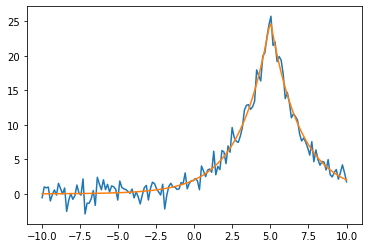

In [105]:
optimal_trials = vizier_client.list_optimal_trials({
    'parent': STUDY_ID
})

optimal_trial = optimal_trials.optimal_trials[0]

print("Optimal trial")
y_hat = GenerateFit(optimal_trial.parameters)

plt.plot(x, y_l_r)
plt.plot(x, y_hat)
plt.show()